# Anchor-Anchor Hidden Distance
**Goal**: Analyze the distance between the hidden representation of each set of anchors

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Anchors Data

In [2]:
all_anchors_data = []

for dilution in range(1, 4):
    # Load probes data
    anchors_data = pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-anchors-hidden.pkl')
    anchors_data['dilution'] = dilution
    all_anchors_data.append(anchors_data)

all_anchors_data = pd.concat(all_anchors_data)

# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')

In [3]:
all_anchors_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution
0,1850,"[0.1502865, 0.5270379, 0.9877482, 0.9991763, 0...",908,gag,gg,0,1
1,1850,"[0.3843217, 0.6729541, 0.984641, 0.7259629, 0....",2231,slough,slf,0,1
2,1850,"[0.9406123, 0.9816927, 0.7636653, 0.9491369, 0...",902,funk,fNk,0,1
3,1850,"[0.005106961, 0.002113011, 0.9451625, 0.918166...",2470,strike,strIk,0,1
4,1850,"[0.1290228, 0.7310894, 0.4717223, 0.9550875, 0...",831,fluke,flUk,0,1


In [4]:
anchor_probe_mapping.head()

,anchor,probes,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


## Calculation of Distance between Probes

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [5]:
results = []
for dilution in [2, 3]:
    anchors_data = all_anchors_data[all_anchors_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        anchor_hidden = anchors_data[anchors_data['orth'].isin(row['anchor'])]

        for epoch in anchors_data['epoch'].unique():
            epoch_anchor_hidden = np.array(anchor_hidden[anchor_hidden['epoch'] == epoch]['hidden'].tolist())

            results.append({
                'dilution': dilution,
                'epoch': epoch,
                'anchors': row['anchor'],
                'type': row['type'],
                'cosine_distances': cosine_distances(epoch_anchor_hidden, epoch_anchor_hidden),
                'l1_distances': manhattan_distances(epoch_anchor_hidden, epoch_anchor_hidden)
            })

Dilution 3: 100%|██████████| 27/27 [00:02<00:00,  9.97it/s]


In [6]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df['first_anchor'] = results_df['anchors'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', 'first_anchor']).reset_index(drop=True)

In [7]:
results_df.head()

,dilution,epoch,anchors,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,2,1850,"[blome, clome, flome]",AMB,"[[0.0, 0.09890904526458766], [0.09890904526458...","[[0.0, 19.926832735809505], [19.92683273580950...",0.049455,9.963416,blome
1,3,1850,"[blome, clome, flome]",AMB,"[[0.0, 0.09890904526458766, 0.0696941977698608...","[[0.0, 19.926832735809505, 16.867430579707], [...",0.055002,12.191612,blome
2,2,1850,"[clead, smead, pread]",AMB,"[[0.0, 0.14438706853535155], [0.14438706853535...","[[0.0, 24.746626241144007], [24.74662624114400...",0.072194,12.373313,clead
3,3,1850,"[clead, smead, pread]",AMB,"[[0.0, 0.14438706853535155, 0.1674454057185508...","[[0.0, 24.746626241144007, 27.080795000170006]...",0.100787,16.985769,clead
4,2,1850,"[frow, clow, trow]",AMB,"[[0.0, 0.1584512668345941], [0.158451266834594...","[[0.0, 27.5560823004], [27.5560823004, 0.0]]",0.079226,13.778041,frow


## Mean Cosine and L1 Distance by Anchor Type

This first pair of graphs aggregate dilution 2 and 3 together.

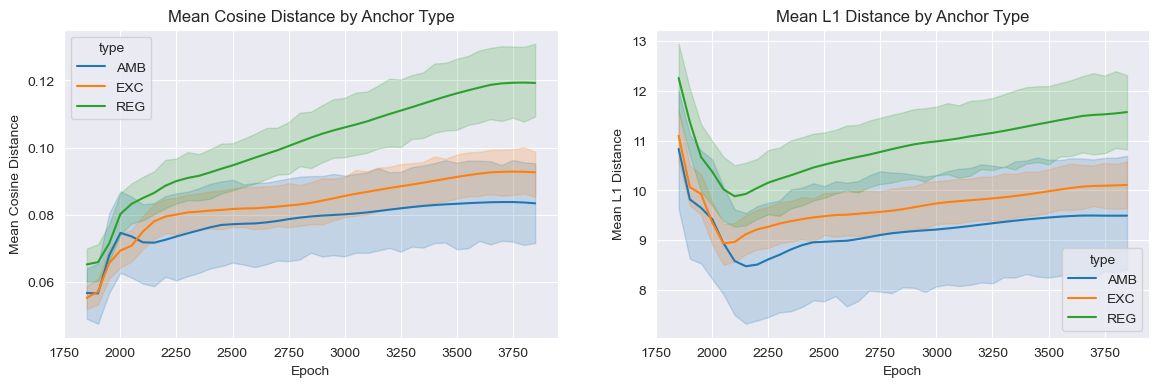

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title('Mean Cosine Distance by Anchor Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title('Mean L1 Distance by Anchor Type')

plt.show()

**Notes**
* As what we would expect, the anchor-anchor distance is even smaller together than the probe-probe distance.
* The distance between regular anchors of the same set is greater than for the exceptions, but I would think that this is more due to our word choices for anchors rather than the warping effects.

In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot.

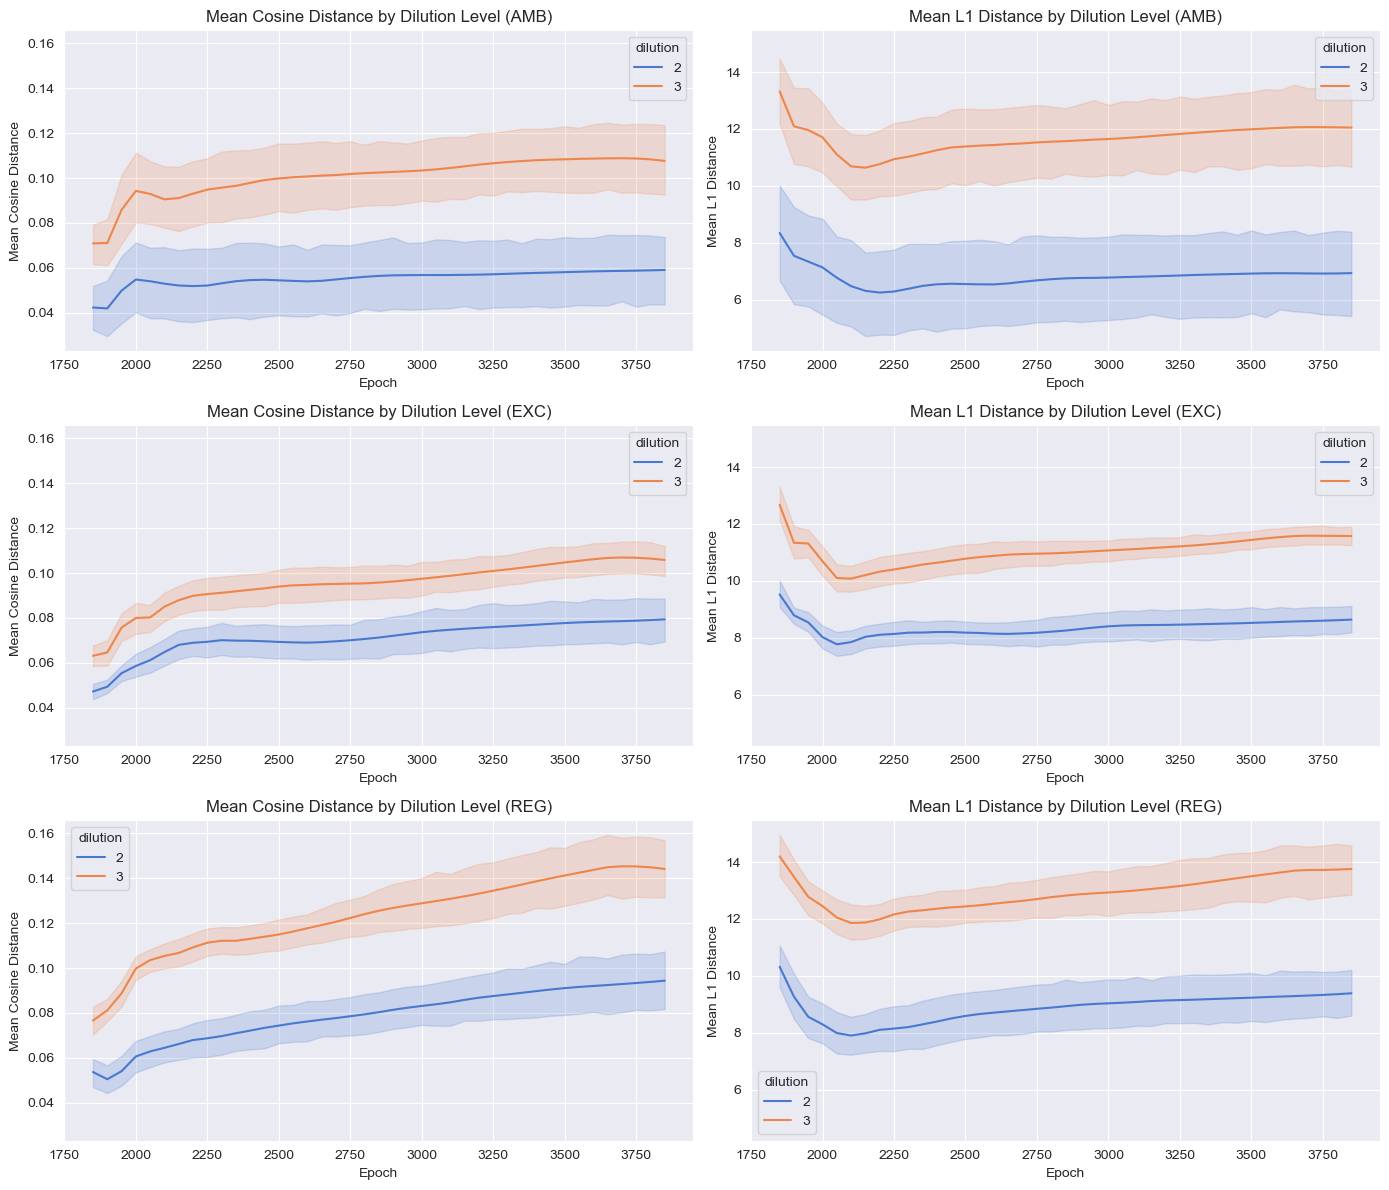

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

**Notes**
* It appears that training has not yet stabilized, as the curves are still increasing (this is especially evident for the exceptions.

In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot.

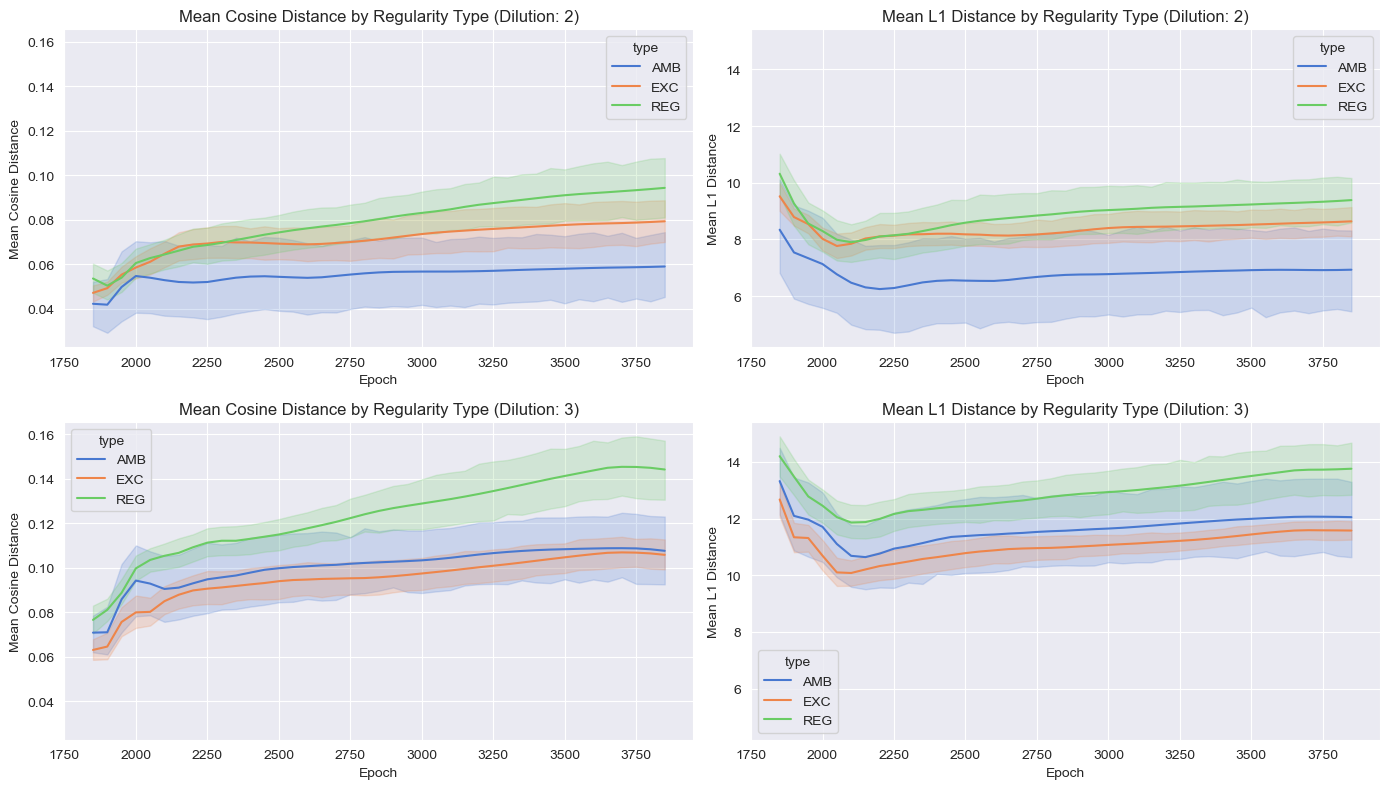

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

## Anchor-Anchor Distance by Set
* We refer to each anchor set by the first anchor.

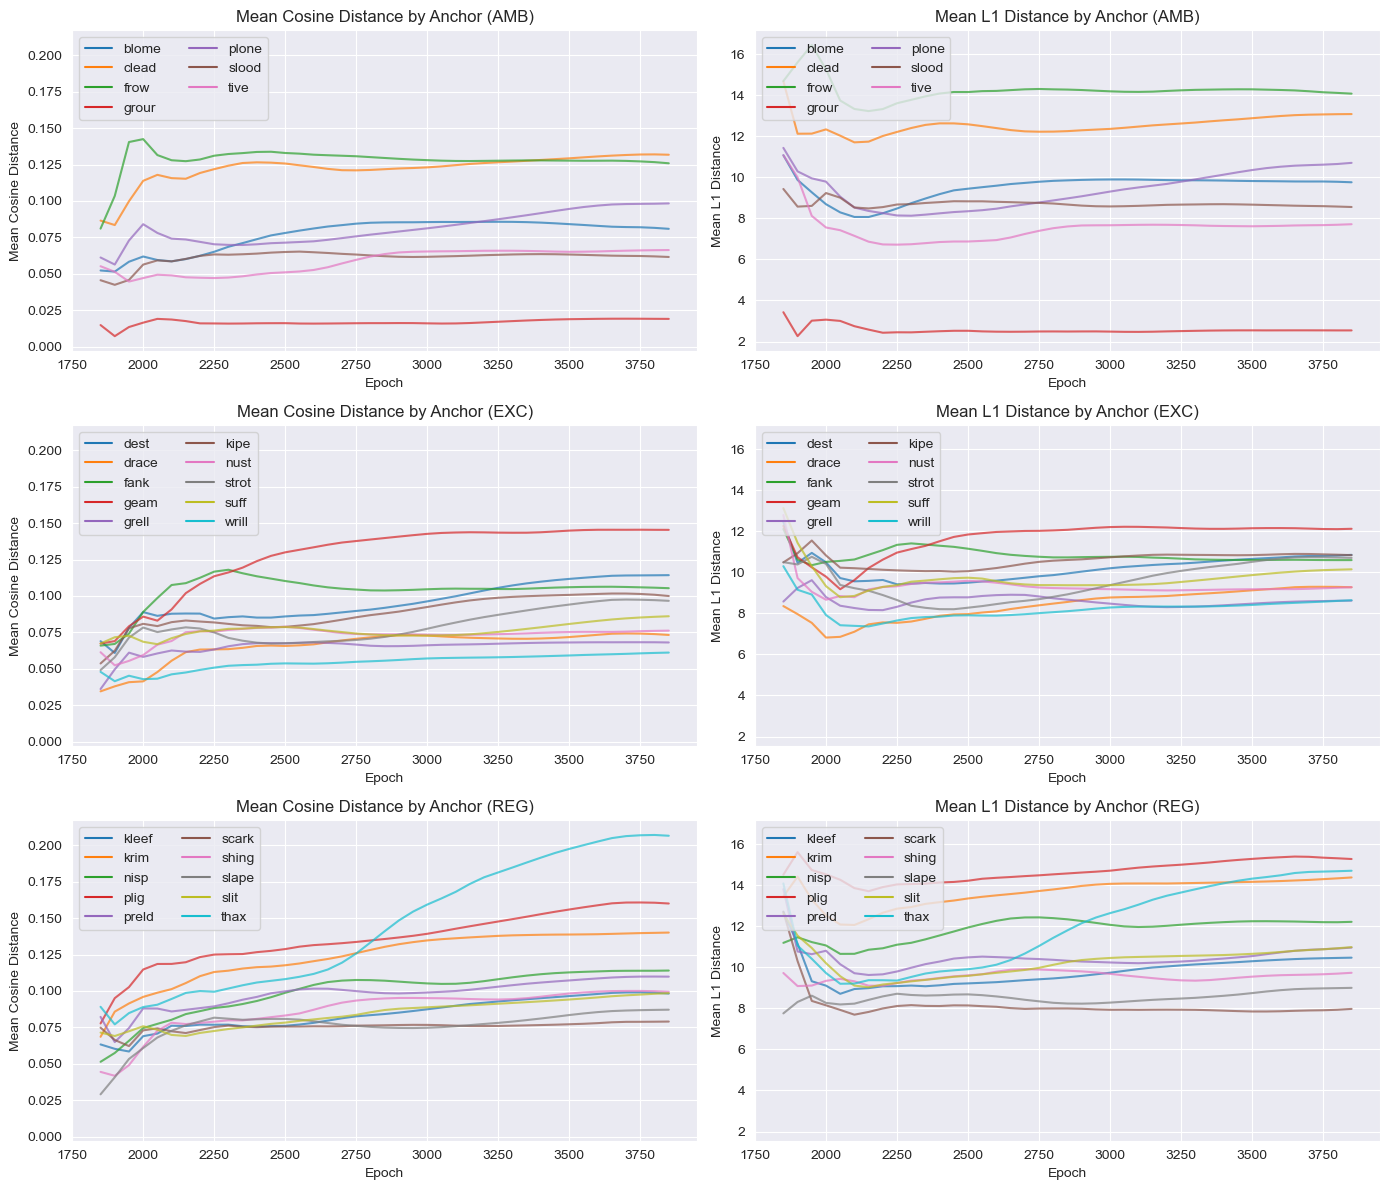

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Anchor ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Anchor ({word_type})')

plt.tight_layout()
plt.show()